## Import required packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

## Environment Variables and Directory Structure

In [2]:
# STEPS=int(os.getenv('STEPS',5))
BATCH_SIZE = int(os.getenv('BATCHSIZE', 64))
EPOCHS = int(os.getenv('EPOCHS', 10))
NUM_CLASSES = 10
DATA_DIR='/opt/dkube/input'
if not os.path.exists('output'):
    os.makedirs('output')
if not os.path.exists('values'):
    os.makedirs('values')
MODEL_DIR='output'

## Unzip the data

In [21]:
path=DATA_DIR+'/train.7z'
path_test=DATA_DIR+'/test.7z'
path_labels=DATA_DIR+'/trainLabels.csv'

In [23]:
import py7zr
with py7zr.SevenZipFile(path, mode='r') as z:
    z.extractall(path="/tmp")

In [5]:
!ls

 7.+Cifar10_feature_map.ipynb   cifar10.h5	       'output\cifar10.h5'
 README.md		        cifar10Training.ipynb   values
 Untitled.ipynb		        output


In [22]:
# with py7zr.SevenZipFile(path_test, mode='r') as z:
#     z.extractall(path="/tmp")

KeyboardInterrupt: 

## Load the data

In [7]:
train_dir = os.listdir('/tmp/train')
train_dir_len = len(train_dir)
print("Length:\t", train_dir_len)

Length:	 50000


In [8]:
train_labels = pd.read_csv(path_labels)
train_images = pd.DataFrame(columns=['id', 'label', 'path'], dtype=str)

In [9]:
train_root = '/tmp/train/'
for i in range(0, train_dir_len):
    path = train_root + str(i+1) + '.png'
    if os.path.exists(path):
        train_images = train_images.append([{
            'id': train_labels['id'].iloc[i],
            'label': train_labels['label'].iloc[i],
            'path': str(i+1) + '.png'
        }])
        
train_images.head()

,id,label,path
0,1,frog,1.png
0,2,truck,2.png
0,3,truck,3.png
0,4,deer,4.png
0,5,automobile,5.png


In [10]:
display_groupby = train_images.groupby(['label']).count()
display_groupby.head(10)

,id,path
label,,
airplane,5000,5000
automobile,5000,5000
bird,5000,5000
cat,5000,5000
deer,5000,5000
dog,5000,5000
frog,5000,5000
horse,5000,5000
ship,5000,5000


In [11]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for name in class_names:
    index = class_names.index(name)
    train_images.loc[train_images['label'] == name, 'label'] = str(index)

display_groupby = train_images.groupby(['label']).count()
display_groupby.head(10)

,id,path
label,,
0,5000,5000
1,5000,5000
2,5000,5000
3,5000,5000
4,5000,5000
5,5000,5000
6,5000,5000
7,5000,5000
8,5000,5000


In [12]:
train_images.head()

,id,label,path
0,1,6,1.png
0,2,9,2.png
0,3,9,3.png
0,4,4,4.png
0,5,1,5.png


## Image Data Generator

In [14]:
data_generator = ImageDataGenerator(rescale=1/255.,
                                   validation_split=0.2,
                                   horizontal_flip=True)

train_generator = data_generator.flow_from_dataframe(dataframe=train_images, 
                                                    directory='/tmp/train/',
                                                    x_col='path',
                                                     y_col='label',
                                                     subset='training',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(32,32),
                                                     class_mode='categorical')

validation_generator = data_generator.flow_from_dataframe(dataframe=train_images,
                                                         directory='/tmp/train/',
                                                         x_col='path',
                                                         y_col='label',
                                                         subset='validation',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=True,
                                                         target_size=(32,32),
                                                         class_mode='categorical')

Found 40000 validated image filenames belonging to 10 classes.
Found 10000 validated image filenames belonging to 10 classes.


## Modeling

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.6, min_denta=0.00001)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

history = model.fit(train_generator, epochs=1, validation_data=validation_generator, callbacks=[reduce_lr, es])

Train for 625 steps, validate for 157 steps
625/625 [==============================] - 166s 266ms/step - loss: 1.5240 - accuracy: 0.4619 - val_loss: 1.1953 - val_accuracy: 0.5710


## Visualize ACCURACY and LOSS

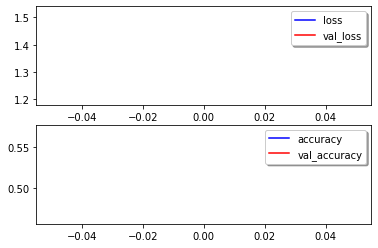

In [18]:
_, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color='b', label='loss')
ax[0].plot(history.history['val_loss'], color='r', label='val_loss')
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label='accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label='val_accuracy')
legend = ax[1].legend(loc='best', shadow=True)

In [19]:
from keras.models import load_model
model.save("cifar10.h5")
# loaded_model = load_model("cifar10.h5")
# loss, accuracy = loaded_model.evaluate(test_data, test_targets)

Using TensorFlow backend.


In [20]:
model.save('output/cifar10.h5')